In [1]:
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from data_processing import prepareData, readLangs, normalizeString, filter_pair, translate_evaluate
from tqdm import tqdm


TRAIN_DATASET_PATH = "./dataset/eng-fra-train.txt"
TEST_DATASET_PATH = "./dataset/eng-fra-test.txt"


In [2]:
MAXLEN = 10
eng, fre, pairs = prepareData(TRAIN_DATASET_PATH, MAXLEN)

SOS_TOKEN = 0
EOS_TOKEN = 1

## FRENCH - TO - ENGLISH

In [3]:
# text vector in hidden layers out
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1) -> None:
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, inputx):
        # print('input shape', inputx.shape)
        embedded = self.dropout(self.embedding(inputx))
        # print('embedding shape', embedded.shape)
        output, hidden = self.gru(embedded)
        # print('gru output hidden', output.shape, hidden.shape)
        return output, hidden

In [4]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size) -> None:
        super(DecoderRNN, self).__init__()
        # print(f'hidden_size: {hidden_size}, output_size:{output_size}')
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long).fill_(SOS_TOKEN)
        # print(f'decoder input: {decoder_input.shape}')
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAXLEN):
            # print(f'decoder HIDDED:{decoder_output.shape} , ')
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            # print(f'decoder output shape: {decoder_output.shape}')
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()
        
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None


    def forward_step(self, inputs, hidden):
        output = self.embedding(inputs)
        output = F.relu(output)
        # print(f'output{output.shape}, hidden: {hidden.shape}')
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [5]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size) -> None:
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size) # has parameters for query (hidden state)
        self.Ua = nn.Linear(hidden_size, hidden_size) # has parameters for key (encoder hidden state)
        self.Va = nn.Linear(hidden_size, 1) 
    
    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = F.softmax(scores, dim=-1) # To produce predictive distribution
        context = torch.bmm(weights, keys)
        return context, weights

class AttnDecoderRNN(nn.Module):

    def __init__(self, hidden_size, output_size, dropout_p=0.1) -> None:
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2*hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward_step(self, input_x, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input_x))
        query = hidden.permute(1, 0, 2)
        context, att_weight = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)
        return output, hidden, att_weight


    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long).fill_(SOS_TOKEN)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAXLEN)        :
            decoder_output, decoder_hidden, attn_weights = self.forward_step(decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)
            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input
        
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)
        return decoder_outputs, decoder_hidden, attentions




In [6]:
def indexesFromSentence(lang, sentence):
    return [lang.word2idx[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = [lang.word2idx[word] for word in sentence.split(' ')]
    sent_idx = torch.tensor(indexes, dtype=torch.long).view(1, -1)
    return sent_idx


def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    output_tensor = tensorFromSentence(output_lang, pair[1])
    return input_tensor, output_tensor

def get_dataloader(batch_size, path=TRAIN_DATASET_PATH):
    fre, eng, pairs = prepareData(path, MAXLEN)
    n = len(pairs)  
    input_ids = np.zeros((n, MAXLEN), dtype=np.int32)
    target_ids = np.zeros((n, MAXLEN), dtype=np.int32)
    
    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(fre, inp)
        tgt_ids = indexesFromSentence(eng, tgt)
        inp_ids.append(EOS_TOKEN)
        tgt_ids.append(EOS_TOKEN)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids),
                               torch.LongTensor(target_ids))
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return fre, eng, train_dataloader, train_data

### TRAINING WITHOUT ATTENTION

In [7]:
input_lang, output_lang, train_dataloader, train_dset = get_dataloader(32)
test_ds = []
with open(TEST_DATASET_PATH) as f:
    for line in f:
        engtext, fretext = line.split('\t')
        test_ds.append([normalizeString(fretext), normalizeString(engtext)])
    test_ds = [pair for pair in test_ds if filter_pair(pair, MAXLEN)]    
    
loss = []
hidden_size = 128
learning_rate = 0.001
encoder = EncoderRNN(input_lang.n_words, hidden_size)
decoder = DecoderRNN(hidden_size, output_lang.n_words)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss() 
EPOCHS = 25

In [8]:

plot_stats = {
    'bleu_test': [],
    'avg_train_loss': [],
    'avg_test_loss': []
}
for epoch in range(EPOCHS):
    dpoints = 0
    epoch_loss = 0
    encoder.train(), decoder.train()
    for batch in tqdm(train_dataloader):
        input_tensor, target_tensor = batch
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        epoch_loss +=loss.item()
        dpoints += input_tensor.shape[0]
    
    bleu_dict, test_loss = translate_evaluate(input_lang, output_lang, test_ds, encoder, decoder)
    plot_stats['bleu_test'].append(bleu_dict['bleu'])
    plot_stats['avg_train_loss'].append(epoch_loss/dpoints)
    plot_stats['avg_test_loss'].append(test_loss)

  0%|          | 0/322 [00:00<?, ?it/s]

100%|██████████| 322/322 [00:07<00:00, 45.28it/s]


## CODE TO SPLIT DATASET

```python 
import random
with open('./dataset/eng-fra.txt', encoding='utf-8') as f:
    arr = f.readlines()
random.shuffle(arr) # shuffles inline
SPLIT_PERCENT = 0.10

n = len(arr)
n_test = round(n * SPLIT_PERCENT)
n_train = n - n_test
train_eng_fra = arr[:n_train]
test_eng_fra = arr[n_train:]
with open('./dataset/eng-fra-train.txt', 'w') as f_train:
    f_train.writelines(train_eng_fra)
with open('./dataset/eng-fra-test.txt', 'w') as f_test:
    f_test.writelines(test_eng_fra)

```

## Training With Attention


In [9]:

at_loss = []

at_encoder = EncoderRNN(input_lang.n_words, hidden_size)
at_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words)
at_encoder_optimizer = optim.Adam(at_encoder.parameters(), lr=learning_rate)
at_decoder_optimizer = optim.Adam(at_decoder.parameters(), lr=learning_rate)
EPOCHS = 25


In [10]:
a_plot_stats = {
    'bleu_test': [],
    'avg_train_loss': [],
    'avg_test_loss': []
}
for epoch in range(EPOCHS): 
    dpoints = 0
    epoch_loss = 0
    at_encoder.train(), at_decoder.train()
    for batch in tqdm(train_dataloader):
        input_tensor, target_tensor = batch
        at_encoder_optimizer.zero_grad()
        at_decoder_optimizer.zero_grad()
        encoder_outputs, encoder_hidden = at_encoder(input_tensor)
        decoder_outputs, decoder_hidden, _ = at_decoder(encoder_outputs, encoder_hidden, target_tensor)
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        at_encoder_optimizer.step()
        at_decoder_optimizer.step()
        epoch_loss +=loss.item()
        dpoints += input_tensor.shape[0]
    
    bleu_dict, test_loss = translate_evaluate(input_lang, output_lang, test_ds, at_encoder, at_decoder)
    a_plot_stats['bleu_test'].append(bleu_dict['bleu'])
    a_plot_stats['avg_train_loss'].append(epoch_loss/dpoints)
    a_plot_stats['avg_test_loss'].append(test_loss)

100%|██████████| 322/322 [00:09<00:00, 32.27it/s]


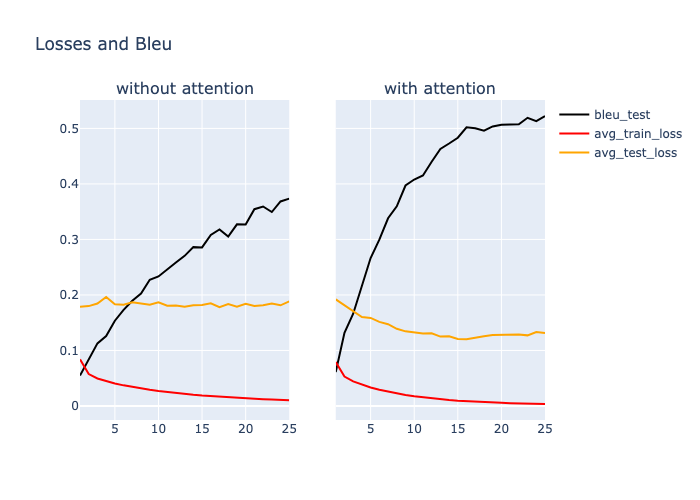

In [18]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

epochs = list(range(1, len(plot_stats['avg_train_loss'])+1))

fig = make_subplots(rows=1, cols=2, shared_yaxes=True, column_titles=["without attention", "with attention"])
colours = {"avg_train_loss":"red", 
 "avg_test_loss": "orange",
 "bleu_test": "black"}

for ks in plot_stats.keys():
    
    y_val = plot_stats[ks]
    y_name = ks
    y_val_a = a_plot_stats[ks]
    y_name_a = ks 

    fig.add_trace(go.Scatter(x=epochs, y=y_val,
                    mode='lines',
                    name=y_name, marker=dict(color= colours[y_name])), row=1, col=1)
    
    fig.add_trace(go.Scatter(x=epochs, y=y_val_a,
                    mode='lines',
                    name=y_name_a, marker=dict(color= colours[y_name_a]), showlegend=False), row=1, col=2)
    
fig.layout['title'] = 'Losses and Bleu'

fig.show(renderer="png")